# Environment Setup

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery

project_id = 'cse-6242-sp22-nyatl'
client = bigquery.Client(project=project_id)

In [ ]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.ensemble import RandomForestRegressor

# Data Setup

In [ ]:
sql = """
 select * from `cse-6242-sp22-nyatl.AGG.weather_trips_per_day`
"""

df = client.query(sql).to_dataframe()
df.head()

,date,num_trips_per_day,Temp_Max,Temp_Avg,Temp_Min,Dew_Max,Dew_Avg,Dew_Min,Humidity_Max,Humidity_Avg,Humidity_Min,Wind_spd_Max,Wind_spd_Avg,Wind_spd_Min,Pressure_Max,Pressure_Avg,Pressure_Min,Precipitation_Total
0,2021-07-11,101890,81,75.7,73,72,67.0,63,87,74.6,54,15,8.5,0,30.1,30.1,30.0,0.06
1,2021-06-01,98338,78,67.4,57,53,49.9,43,84,56.5,29,17,5.8,0,30.3,30.2,30.2,0.00
2,2021-06-21,100318,87,80.0,74,70,68.3,65,82,67.9,57,20,11.6,8,29.7,29.7,29.6,0.00
3,2021-04-28,94825,82,62.2,51,56,46.9,42,78,59.1,33,13,7.1,0,29.9,29.8,29.7,0.00
4,2021-06-10,119760,80,75.0,66,66,54.7,44,76,50.3,31,17,9.6,0,30.1,30.0,29.9,0.00


In [ ]:
x_train_all, x_test_all, y_train, y_test = train_test_split(df.loc[:,df.columns != 'num_trips_per_day'], df['num_trips_per_day'], test_size=0.30, random_state=614, shuffle=True)
x_train = x_train_all.iloc[:,1:17]
x_test = x_test_all.iloc[:,1:17]

print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

(1043, 16)
(447, 16)
(1043,)
(447,)


# Random Forest Regression

In [ ]:
rf_reg = RandomForestRegressor(n_estimators = 1000, random_state = 614).fit(x_train, y_train)
y_predict_train = rf_reg.predict(x_train)
y_predict_test = rf_reg.predict(x_test)

In [ ]:
# Get numerical feature importances
importances = list(rf_reg.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(df.columns[2:18], importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Factor: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Factor: Temp_Avg             Importance: 0.49
Factor: Temp_Max             Importance: 0.11
Factor: Humidity_Avg         Importance: 0.09
Factor: Wind_spd_Avg         Importance: 0.04
Factor: Temp_Min             Importance: 0.03
Factor: Dew_Avg              Importance: 0.03
Factor: Dew_Min              Importance: 0.03
Factor: Humidity_Max         Importance: 0.03
Factor: Humidity_Min         Importance: 0.03
Factor: Wind_spd_Max         Importance: 0.03
Factor: Dew_Max              Importance: 0.02
Factor: Pressure_Avg         Importance: 0.02
Factor: Pressure_Min         Importance: 0.02
Factor: Wind_spd_Min         Importance: 0.01
Factor: Pressure_Max         Importance: 0.01
Factor: Precipitation_Total  Importance: 0.01


# Accuracy

In [ ]:
# Calculate the absolute errors
errors = abs(y_predict_test - y_test)
# Print out the mean absolute error (mae)
# print('Mean Absolute Error:', round(np.mean(errors)), 'rides.')

# Calculate mean absolute percentage error (MAPE)
mape = (errors / y_test)
print ("Mean Absolute Percentage Deviation:", round(np.mean(mape) * 100, 2), "%")
# Calculate and display accuracy
accuracy = 100 - np.mean(mape * 100)
print('Accuracy:', round(accuracy, 2), '%.')

MSE = np.square(np.subtract(y_test,y_predict_test)).mean() 
RMSE = math.sqrt(MSE)
print("Root Mean Squared Error:", round(RMSE), "rides.")


Mean Absolute Percentage Deviation: 28.57 %
Accuracy: 71.43 %.
Root Mean Squared Error: 15674 rides.


# Visualization

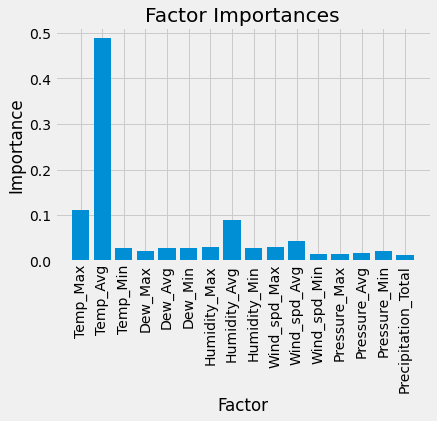

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, df.columns[2:18], rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Factor'); plt.title('Factor Importances');

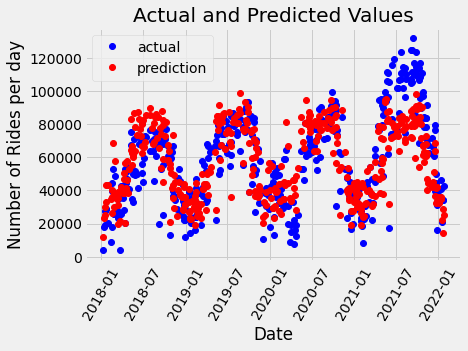

In [ ]:
# Use datetime for creating date objects for plotting
import datetime
# training values
dates = x_test_all.iloc[:, 0]
true_data = pd.DataFrame(data = {'date': dates, 'actual': y_test})
# test values
test_dates = x_test_all.iloc[:, 0]
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': y_predict_test})

# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'bo', label = 'actual')
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Number of Rides per day'); plt.title('Actual and Predicted Values');

# HyperTuning

In [ ]:
parameters = {'n_estimators': [4, 16, 256, 512, 1024], 'max_depth': [2, 8, 16]}
gscv_rfc = GridSearchCV(rf_reg, parameters).fit(x_train, y_train)

print("best_params:", gscv_rfc.best_params_)
print("best_score: ", gscv_rfc.best_score_)

best_params: {'max_depth': 8, 'n_estimators': 1024}
best_score:  0.6320852238516635


In [ ]:
rf2_reg = RandomForestRegressor(n_estimators = 1024, random_state = 42, max_depth=8).fit(x_train, y_train)
y2_predict_train = rf2_reg.predict(x_train)
y2_predict_test = rf2_reg.predict(x_test)

# Calculate the absolute errors
errors = abs(y2_predict_test - y_test)
# Print out the mean absolute error (mae)
# print('Mean Absolute Error:', round(np.mean(errors)), 'rides.')

# Calculate mean absolute percentage error (MAPE)
mape = (errors / y_test)
print ("Mean Absolute Percentage Deviation:", round(np.mean(mape) * 100, 2), "%")
# Calculate and display accuracy
accuracy = 100 - np.mean(mape * 100)
print('Accuracy:', round(accuracy, 2), '%.')

MSE = np.square(np.subtract(y_test,y2_predict_test)).mean() 
RMSE = math.sqrt(MSE)
print("Root Mean Squared Error:", round(RMSE), "rides.")

Mean Absolute Percentage Deviation: 28.62 %
Accuracy: 71.38 %.
Root Mean Squared Error: 15644 rides.
